In [1]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import lognorm

In [2]:
TYPE_1 = 1
TYPE_2 = 2
TYPE_3 = 3
TYPE_4 = 4

ALL_TYPES = [TYPE_1, TYPE_2, TYPE_3, TYPE_4]

ROUTE_1 = 1
ROUTE_2 = 2
ROUTE_3 = 3
ROUTE_4 = 4
ROUTE_5 = 5

ALL_ROUTES = [ROUTE_1, ROUTE_2, ROUTE_3, ROUTE_4, ROUTE_5]

class Request:
    TYPE_NAME = 'Тип сообщения'
    LENGTH_NAME = 'Длина сообщения'
    TIME_NAME = 'Время поступления'
    DEST_NAME = 'Адрес абонента'
    
    def __init__(self, typ, length, time, destination):
        self.type = typ
        self.length = length
        self.time = time
        self.destination = destination
        
    def attrs(self):
        return [
            self.type, 
            self.length, 
            self.time, 
            self.destination
        ]
    
    @classmethod
    def attr_names(cls):
        return [
            cls.TYPE_NAME, 
            cls.LENGTH_NAME, 
            cls.TIME_NAME, 
            cls.DEST_NAME
        ]
    
    def __repr__(self):
        return f"{self.type} {self.length} {self.time} {self.destination}"
    

class Router:
    routes = {
        TYPE_1: [0.66, 0.11, 0.1, 0.01, 0.12],
        TYPE_2: [0.22, 0.35, 0.26, 0.08, 0.09],
        TYPE_3: [0.58, 0.06, 0.24, 0.02, 0.1],
        TYPE_4: [0.42, 0.29, 0.16, 0.1, 0.03],
    }

    def route(self, request_type):
        if request_type not in self.routes:
            raise RuntimeError('Unknown request type')
        
        return np.random.choice(ALL_ROUTES, p=self.routes[request_type])
        

class RequestGenerator:
    TYPES_PROBABILITY = [0.69, 0.06, 0.1, 0.15]
    LENGTH_RANGE = (11, 235)
    
    INCOME_MEDIAN = 0.4
    INCOME_VARIANCE = 4.2
    
    def __init__(self, sample_size):
        self.sample_size = sample_size
        
        rv = lognorm(math.sqrt(self.INCOME_VARIANCE), scale=math.exp(self.INCOME_MEDIAN))
        self.income_distribution = iter(rv.rvs(sample_size))
        
        self.router = Router()
        self.samples = []
    
    def generate_request(self):
        request_type = np.random.choice(ALL_TYPES, p=self.TYPES_PROBABILITY)
        request_length = random.randrange(*self.LENGTH_RANGE)
        request_time = next(self.income_distribution)
        request_destination = self.router.route(request_type)
        
        return Request(
            request_type,
            request_length,
            request_time,
            request_destination
        )
    
    def generate_samples(self):
        self.samples = [self.generate_request() for _ in range(self.sample_size)]
        self.samples = sorted(self.samples, key=lambda request: request.time)
        
    def as_df(self):
        if not self.samples:
            raise ValueError("Generate samples first.")
        
        return pd.DataFrame(
            data=[request.attrs() for request in self.samples], 
            columns=Request.attr_names()
        )



In [3]:

class QueueAnalyzer:
    def __init__(self, generator: RequestGenerator):
        self.generator = generator
        self.df = generator.as_df()
        
    def data_table(self):
        return self.df
    
    def plot_distribution(self):
        data = self.df[Request.TIME_NAME]

        fig, ax1 = plt.subplots()
        ax2 = ax1.twinx()
        
        plt.title('Значения времени поступления и функция плотности вероятности')
        
        ax1.set_ylabel('Количество заявок', color='skyblue')
        ax1.set_xlabel('Время поступления')
        
        ax2.set_ylabel('Плотность вероятности', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')
        
        # Оценка параметров распределения lognorm по данным
        shape, loc, scale = lognorm.fit(data)
        
        # Генерация значений для функции плотности вероятности
        x_values = np.linspace(min(data), max(data), 1000)
        pdf_values = lognorm.pdf(x_values, shape, loc=loc, scale=scale)
        
        # Гистограмма
        hist = ax1.hist(data, bins='auto', color='skyblue', edgecolor='black', alpha=0.7, label='Заявки')
        
        # Функция плотности вероятности
        plot = ax2.plot(x_values, pdf_values, color='orange', label='Функция плотности вероятности (lognorm)')
        
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        
        ax1.legend(lines + lines2, labels + labels2, loc=0)
        ax1.grid()

        
    def request_type_stat_table(self):
        count_per_type = self.df[Request.TYPE_NAME].value_counts().sort_index()
        
        # Подсчет вероятности появления каждого типа
        probability_per_type = count_per_type / self.generator.sample_size
        
        # Создание DataFrame для результатов
        return pd.DataFrame({
            'Кол-во заявок данного типа': count_per_type,
            'Вероятность появления заявки (полученная)': probability_per_type,
            'Вероятность появления заявки (заданная)': RequestGenerator.TYPES_PROBABILITY,
        })
    
    def request_length_stat_table(self):
        grouped_by_type = self.df.groupby(Request.TYPE_NAME)
        return pd.DataFrame({
            'Средняя длина заявки': grouped_by_type[Request.LENGTH_NAME].mean(),
            'Предельная длина заявки': grouped_by_type[Request.LENGTH_NAME].max()
        })
    
    def destination_stat_table(self):
        grouped = self.df.groupby([Request.DEST_NAME])
        time = self.df[Request.TIME_NAME].max()
        
        print('Max time is', time)
        return pd.DataFrame({
            'Количество заявок': grouped.size(),
            'Средняя частота поступления заявок': grouped.size() / time
        })
    
    def destination_and_type_stat_table(self):
        multiindex = pd.MultiIndex.from_product([ALL_TYPES, ALL_ROUTES], names=[Request.TYPE_NAME, Request.DEST_NAME])

        grouped = self.df.groupby([Request.TYPE_NAME, Request.DEST_NAME])
        
        count_per_type_per_address = grouped.size().unstack(fill_value=0)
        
        total_count_per_address = grouped.size().reset_index(name='Total').groupby(Request.TYPE_NAME)['Total'].sum()
        
        probability_per_type_per_address = count_per_type_per_address.divide(total_count_per_address, axis=0)
         
        result_df = pd.DataFrame({
            'Число заявок': count_per_type_per_address.values.flatten(),
            'Вероятность заявки': probability_per_type_per_address.values.flatten(),
        }, index=multiindex)
        
        theoretical_probabilities = [Router.routes[tp][addr - 1] for tp, addr in result_df.index]
        
        result_df['Теоретическая вероятность'] = theoretical_probabilities

        
        return result_df

    def request_time_stat_table(self):
        grouped = self.df.groupby(Request.TYPE_NAME)

        # Подсчет математического ожидания, дисперсии и стандартного отклонения для каждого типа заявок
        statistics = grouped[Request.TIME_NAME].agg(['mean', 'var', 'std'])
        
        count_per_type = grouped.size()
        max_time_per_type = grouped[Request.TIME_NAME].max()
        
        statistics['Интенсивность'] = count_per_type / max_time_per_type
        
        # Переименование столбцов для ясности
        statistics.columns = ['Мат. ожидание', 'Дисперсия', 'Стандартное отклонение', 'Интенсивность']
        
        return statistics

    

In [4]:
generator = RequestGenerator(100)
generator.generate_samples()

analyzer = QueueAnalyzer(generator)

# Таблица 1. Полученные заявки.
analyzer.data_table()

,Тип сообщения,Длина сообщения,Время поступления,Адрес абонента
0,2,167,0.003085,2
1,1,203,0.023423,1
2,1,112,0.024412,1
3,1,183,0.031494,1
4,1,74,0.041776,1
...,...,...,...,...
95,1,34,17.043536,1
96,1,144,19.029585,1
97,1,81,36.606361,1
98,4,93,42.735975,1


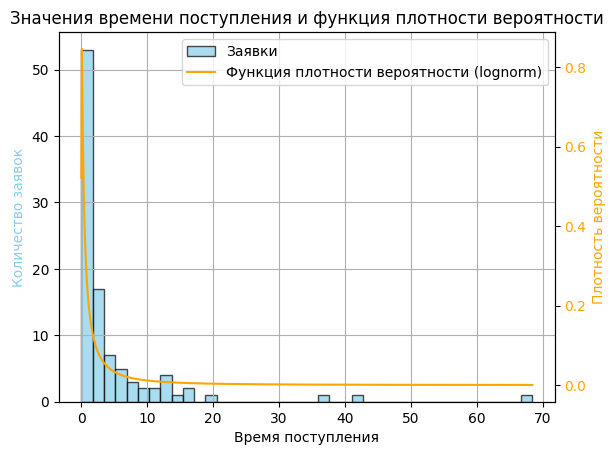

In [5]:
# Рисунок 2. Значения времени поступления и функция плотности вероятности
analyzer.plot_distribution()

In [6]:
# Таблица 2. Сравнение вероятностей появления сообщений (заданная и полученная).
analyzer.request_type_stat_table()

,Кол-во заявок данного типа,Вероятность появления заявки (полученная),Вероятность появления заявки (заданная)
Тип сообщения,,,
1,68,0.68,0.69
2,3,0.03,0.06
3,10,0.10,0.10
4,19,0.19,0.15


In [7]:
# Таблица 3. Сравнение средней длины заявки.
analyzer.request_length_stat_table()

,Средняя длина заявки,Предельная длина заявки
Тип сообщения,,
1,126.691176,232
2,159.000000,185
3,148.200000,234
4,136.315789,233


In [8]:
# Таблица 4. Средняя частота поступления заявок.
analyzer.destination_stat_table()

Max time is 68.42224695569523


,Количество заявок,Средняя частота поступления заявок
Адрес абонента,,
1,66,0.964599
2,18,0.263072
3,11,0.160766
4,1,0.014615
5,4,0.058461


In [9]:
# Таблица 5. Данные о вероятности и числе заявок в потоке.
analyzer.destination_and_type_stat_table()


Число заявок  Вероятность заявки  \
Тип сообщения Адрес абонента                                     
1             1                         53            0.779412   
              2                          7            0.102941   
              3                          4            0.058824   
              4                          0            0.000000   
              5                          4            0.058824   
2             1                          0            0.000000   
              2                          2            0.666667   
              3                          1            0.333333   
              4                          0            0.000000   
              5                          0            0.000000   
3             1                          6            0.600000   
              2                          0            0.000000   
              3                          4            0.400000   
              4                          0            0.000000   
              5                          0            0.000000   
4             1                          7            0.368421   
              2                          9            0.473684   
              3                          2            0.105263   
              4                          1            0.052632   
              5                          0            0.000000   

                              Теоретическая вероятность  
Тип сообщения Адрес абонента                             
1             1                                    0.66  
              2                                    0.11  
              3                                    0.10  
              4                                    0.01  
              5                                    0.12  
2             1                                    0.22  
              2                                    0.35  
              3                                    0.26  
              4                                    0.08  
              5                                    0.09  
3             1                                    0.58  
              2                                    0.06  
              3                                    0.24  
              4                                    0.02  
              5                                    0.10  
4             1                                    0.42  
              2                                    0.29  
              3                                    0.16  
              4                                    0.10  
              5                                    0.03

In [10]:
# Таблица 6. Числовые характеристики типов сообщений
analyzer.request_time_stat_table()


,Мат. ожидание,Дисперсия,Стандартное отклонение,Интенсивность
Тип сообщения,,,,
1,4.760916,97.118374,9.854866,0.993829
2,0.148724,0.018482,0.135949,11.018110
3,5.491101,29.593722,5.440011,0.779053
4,4.156837,95.581329,9.776570,0.444590
